# Imperial College Advanced Hackspace (ICAH) Survey

In [1]:
%matplotlib inline

In [2]:
def import_data(filepath='./icah/Advanced Hackspace Community Survey_March 18, 2019_03.17.tsv', ignore={'Response Type':'Survey Preview'}, duration_cutoff=float('inf'), progress_cutoff=100):
    from pandas import read_csv
    dat = read_csv(filepath, sep='\t', skiprows=[0,2], parse_dates=['Start Date', 'End Date', 'Recorded Date'])
    for key, val in ignore.items(): dat = dat[dat[key]!=val]
    dat = dat[dat['Duration (in seconds)']<=duration_cutoff]
    dat = dat[dat['Progress']>=progress_cutoff]
    return dat

In [3]:
dat = import_data()
print(dat.shape)
print('\n'.join(list(dat)))

(191, 97)
Start Date
End Date
Response Type
Progress
Duration (in seconds)
Finished
Recorded Date
Response ID
Distribution Channel
User Language
EDU - Selected Choice
EDU - Other (please fill in) - Text
OLD
DEP
DEPOTH
GEN - Selected Choice
GEN - Other (please fill in) - Text
NAT
AHM
AHFRE
AHTIM
AHHIR
AHSRC - Selected Choice
AHSRC - Other (please fill in) - Text
AHSOC - Selected Choice
AHSOC - Other (please fill in) - Text
AHPRO
AHSAF - I am aware of what a 'near miss' is and the importance of reporting these at ICAH
AHSAF - I am aware of how to report an accident or near miss at ICAH
AHSAF - ICAH is delighted to hear about near-misses
AHSAF - I feel safer in the case of an accident or near miss at ICAH, than I do in a departmental lab
AHSAF - Safety is central to ICAH community values
AHSAF - ICAH is a safe environment to work in
AHNRM
AHTEA
AHCOM - ICAH is a welcoming environment
AHCOM - ICAH facilitates collaborative working
AHCOM - I feel like I can ask questions/for help from Hacks

In [4]:
def count_attribute(df, att, by_att=None, norm=True, ignore=['Do not wish to answer', 'Do not know'], plot=True):
    df = df.replace(ignore, [None]*len(ignore))
    if plot:
        import matplotlib.pyplot as plt
        if plot=='small': plt.figure(dpi=80)
        else: plt.figure(dpi=160)
        from seaborn import countplot
        if by_att is None: countplot(y=att, data=df)
        else: countplot(y=by_att, hue=att, data=df)
        plt.show()
    if by_att is None: counts = df[att].value_counts()
    else:
        from pandas import concat
        groups = df[[att, by_att]].groupby(by_att)
        names = list()
        counts = list()
        for name, group in groups:
            names.append(name)
            counts.append(group[att].value_counts())
        counts = concat(counts, axis=1, keys=names, sort=True)
    if norm: counts = counts/counts.sum()
    counts.fillna(0, inplace=True)
    return counts

In [5]:
def dist_attribute(df, att, by_att=None, plot=True, max_limit=float('inf')):
    keep = df[att]<=max_limit
    if plot:
        from seaborn import distplot
        distplot(df[att][keep])
    return df[att][keep].mean(), df[att][keep].std()

(502.0705882352941, 269.89120263544527)


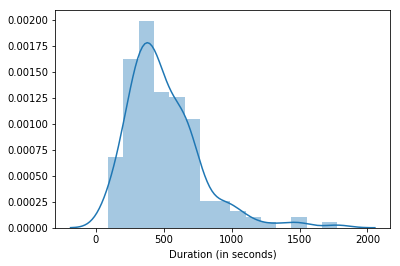

In [6]:
print(dist_attribute(dat, 'Duration (in seconds)', max_limit=1800))

In [7]:
print('survey duration:', dat['End Date'][0]-dat['Start Date'][0], '| duration from qualtrics:', dat['Duration (in seconds)'][0], 'seconds | recording date:', dat['Recorded Date'][0])

survey duration: 0 days 00:05:01 | duration from qualtrics: 301 seconds | recording date: 2019-02-12 10:18:46


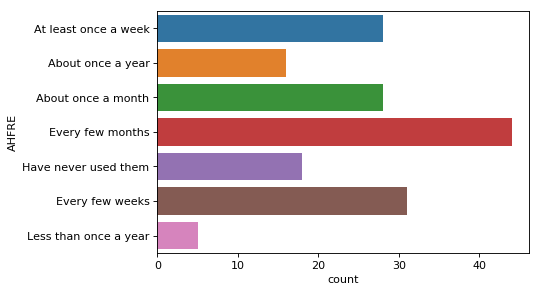

Every few months         0.258824
Every few weeks          0.182353
At least once a week     0.164706
About once a month       0.164706
Have never used them     0.105882
About once a year        0.094118
Less than once a year    0.029412
Name: AHFRE, dtype: float64


In [8]:
print(count_attribute(dat, 'AHFRE', plot='small'))

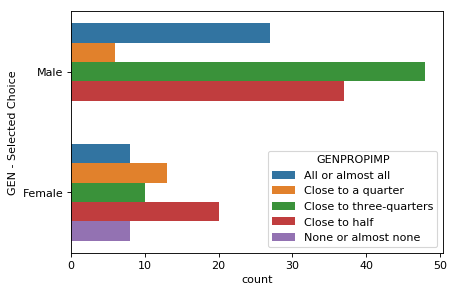

                           Female      Male
All or almost all        0.135593  0.228814
Close to a quarter       0.220339  0.050847
Close to half            0.338983  0.313559
Close to three-quarters  0.169492  0.406780
None or almost none      0.135593  0.000000


In [9]:
print(count_attribute(dat, 'GENPROPIMP', 'GEN - Selected Choice', ignore=['Do not wish to answer', 'Do not know', 'Trans-male', 'Trans-female', 'Other (please fill in)'], plot='small'))

In [10]:
def generate_sbm_params(df):
    #define key variables
    blau_dims = ['GEN', 'EDU', 'OLD', 'DEP', 'NAT', 'INC']
    choice_qs = ['GEN', 'EDU']
    resp_vars = [i+' - Selected Choice' if i in choice_qs else i for i in blau_dims]
    prop_imp_vars = [i+'PROPIMP' for i in blau_dims]+[i+'IMP' for i in ['NUM', 'FRE']]
    prop_icah_vars = [i+'PROPICAH' for i in blau_dims]+[i+'ICAH' for i in ['NUM', 'FRE']]
    prop_ops_1 = ['All or almost all', 'Close to three-quarters', 'Close to half', 'Close to a quarter', 'None or almost none']
    prop_ops_2 = ['All', 'More than half', 'About half', 'Less than half', 'None']
    prop_value = [1.0, 0.75, 0.5, 0.25, 0.0]
    prop_ops = dict(zip(prop_ops_1+prop_ops_2, prop_value*2))
    #blau dims
    gen_ignore = ['Do not wish to answer', 'Do not know', 'Trans-male', 'Trans-female', 'Other (please fill in)']
    shape = []
    names_all = []
    pis_all = []
    rhos_imp_all = []
    rhos_icah_all = []
    omegas_imp_all = []
    omegas_icah_all = []
    for i in range(len(blau_dims)):
        names = []
        pis = []
        rhos_imp = []
        rhos_icah = []
        omegas_imp = []
        omegas_icah = []
        if blau_dims[i]=='GEN':
            pi = count_attribute(df, resp_vars[i], ignore=gen_ignore, plot=False)
            rho_imp = count_attribute(df, prop_imp_vars[i], resp_vars[i], ignore=gen_ignore, plot=False)
            rho_icah = count_attribute(df, prop_icah_vars[i], resp_vars[i], ignore=gen_ignore, plot=False)
            omega_imp = count_attribute(df, 'NUMIMP', resp_vars[i], ignore=gen_ignore, plot=False)
            omega_icah = count_attribute(df, 'NUMICAH', resp_vars[i], ignore=gen_ignore, plot=False)
        else:
            pi = count_attribute(df, resp_vars[i], plot=False)
            rho_imp = count_attribute(df, prop_imp_vars[i], resp_vars[i], plot=False)
            rho_icah = count_attribute(df, prop_icah_vars[i], resp_vars[i], plot=False)
            omega_imp = count_attribute(df, 'NUMIMP', resp_vars[i], plot=False)
            omega_icah = count_attribute(df, 'NUMICAH', resp_vars[i], plot=False)
        for vname in pi.index:
            names.append(vname)
            pis.append(pi.loc[vname])
            rhos_imp.append(sum([prop_ops[i]*rho_imp[vname][i] for i in rho_imp.index]))
            rhos_icah.append(sum([prop_ops[i]*rho_icah[vname][i] for i in rho_icah.index]))
            omegas_imp.append(sum([int(i)*omega_imp[vname][i] for i in omega_imp.index]))
            omegas_icah.append(sum([int(i)*omega_icah[vname][i] for i in omega_icah.index]))
        shape.append(len(names))
        names_all.append((blau_dims[i], tuple(names)))
        pis_all.append(tuple(pis))
        rhos_imp_all.append(tuple(rhos_imp))
        rhos_icah_all.append(tuple(rhos_icah))
        omegas_imp_all.append(tuple(omegas_imp))
        omegas_icah_all.append(tuple(omegas_icah))
    return {'shape':tuple(shape), 'name':tuple(names_all), 'pi':tuple(pis_all), 'rho_imp':tuple(rhos_imp_all), 'rho_icah':tuple(rhos_icah_all), 'omega_imp':tuple(omegas_imp_all), 'omega_icah':tuple(omegas_icah_all)}

In [11]:
sbm_params = generate_sbm_params(dat)

In [1]:
from egosbm import EgocentricSBM
#sbm_imp = EgocentricSBM(shape=sbm_params['shape'], dims=sbm_params['name'], name='icah-imp')
#sbm_imp.set_pi(sbm_params['pi'])
#sbm_imp.set_rho(sbm_params['rho_imp'])
#sbm_imp.set_omega(sbm_imp.correct_omega(sbm_params['omega_imp']))
#sbm_imp.save()
sbm_imp = EgocentricSBM(filepath='icah-imp.ego')

In [2]:
#sbm_icah = EgocentricSBM(shape=sbm_params['shape'], dims=sbm_params['name'], name='icah-icah')
#sbm_icah.set_pi(sbm_params['pi'])
#sbm_icah.set_rho(sbm_params['rho_icah'])
#sbm_icah.set_omega(sbm_icah.correct_omega(sbm_params['omega_icah']))
#sbm_icah.save()
sbm_icah = EgocentricSBM(filepath='icah-icah.ego')

In [3]:
print(sbm_imp)

name:     icah-imp
ndim:     6
shape:    (2, 8, 5, 23, 39, 4)
          
|dims|    |blocks|
GEN       ('Male', 'Female')
EDU       ('an Undergraduate student', 'a Postgraduate research student', 'a Postgraduate taught student', 'Non-academic staff', 'an Imperial College Alum', 'a Research fellow or associate', 'Other (please fill in)', 'Academic staff')
OLD       ('less than a year', 'more than 4 years', '2 to 3 years', '3 to 4 years', '1 to 2 years')
DEP       ('Dyson School of Design Engineering', 'Mechanical Engineering', 'Chemistry', 'Electrical and Electronic Engineering', 'Bioengineering', 'Department of Medicine', 'Physics', 'Computing', 'Aeronautics', 'Materials', 'Civil and Environmental Engineering', 'Enterprise or Advanced Hackspace', 'Other', 'Life Sciences', 'National Heart and Lung Institute', 'Earth Science and Engineering', 'Library', 'Department of Surgery and Cancer', 'Chemical Engineering', 'Finance', 'School of Public Health', 'Mathematics', 'Management')
NAT       

In [4]:
print(sbm_icah)

name:     icah-icah
ndim:     6
shape:    (2, 8, 5, 23, 39, 4)
          
|dims|    |blocks|
GEN       ('Male', 'Female')
EDU       ('an Undergraduate student', 'a Postgraduate research student', 'a Postgraduate taught student', 'Non-academic staff', 'an Imperial College Alum', 'a Research fellow or associate', 'Other (please fill in)', 'Academic staff')
OLD       ('less than a year', 'more than 4 years', '2 to 3 years', '3 to 4 years', '1 to 2 years')
DEP       ('Dyson School of Design Engineering', 'Mechanical Engineering', 'Chemistry', 'Electrical and Electronic Engineering', 'Bioengineering', 'Department of Medicine', 'Physics', 'Computing', 'Aeronautics', 'Materials', 'Civil and Environmental Engineering', 'Enterprise or Advanced Hackspace', 'Other', 'Life Sciences', 'National Heart and Lung Institute', 'Earth Science and Engineering', 'Library', 'Department of Surgery and Cancer', 'Chemical Engineering', 'Finance', 'School of Public Health', 'Mathematics', 'Management')
NAT      

In [5]:
print(sbm_imp.keys())
print(sbm_imp.mean_homophily())
print(sbm_icah.mean_homophily())

('GEN', 'EDU', 'OLD', 'DEP', 'NAT', 'INC')
[0.6309665597801191, 0.8347254608649743, 0.7973074046372476, 0.690577993850245, 0.3768683862433864, 0.5611535657325131]
[0.7040443669475926, 0.5321573060447405, 0.7658376963350785, 0.33739092495636996, 0.2698412698412698, 0.3258869701726844]


In [6]:
print('compression stats:\n', sbm_imp.compress())
print('\nnew shape:', sbm_imp.shape)
print('\nnew mean homophily:\n', sbm_imp.mean_homophily())

compression stats:
 (('GEN', {'loss': 0.0, 'rate': 0.0}), ('EDU', {'loss': -0.01, 'rate': 0.375}), ('OLD', {'loss': 0.0, 'rate': 0.0}), ('DEP', {'loss': -0.014, 'rate': 0.652}), ('NAT', {'loss': -0.081, 'rate': 0.897}), ('INC', {'loss': -0.003, 'rate': 0.25}))

new shape: (2, 5, 5, 8, 4, 3)

new mean homophily:
 [0.6309665597801191, 0.8447585281839574, 0.7973074046372476, 0.7041950720286088, 0.4578195054125373, 0.564066280056267]


C:\Users\sl2416\Documents\phd\dat\egosbm.py:714: RuntimeWarning: expected at least 2 blocks to be merged together, no merge performed for dim 1
  warn('expected at least 2 blocks to be merged together, no merge performed for dim %s'%str(key), RuntimeWarning)
C:\Users\sl2416\Documents\phd\dat\egosbm.py:714: RuntimeWarning: expected at least 2 blocks to be merged together, no merge performed for dim 3
  warn('expected at least 2 blocks to be merged together, no merge performed for dim %s'%str(key), RuntimeWarning)


In [7]:
sbm_icah.compress()

(('GEN', {'loss': 0.0, 'rate': 0.0}),
 ('EDU', {'loss': -0.003, 'rate': 0.5}),
 ('OLD', {'loss': 0.0, 'rate': 0.0}),
 ('DEP', {'loss': -0.104, 'rate': 0.783}),
 ('NAT', {'loss': -0.256, 'rate': 0.923}),
 ('INC', {'loss': -0.016, 'rate': 0.25}))

In [8]:
print(sbm_imp.keys(), sbm_imp.shape, sbm_icah.shape)

('GEN', 'EDU', 'OLD', 'DEP', 'NAT', 'INC') (2, 5, 5, 8, 4, 3) (2, 4, 5, 5, 3, 3)


In [9]:
sbm_imp.get_name(['EDU','DEP','NAT'])

(('an Undergraduate student',
  'a Postgraduate research student',
  'a Postgraduate taught student',
  'Non-academic staff',
  '(an Imperial College Alum) | ((a Research fellow or associate) | ((Other (please fill in)) | (Academic staff)))'),
 ('Dyson School of Design Engineering',
  'Mechanical Engineering',
  'Chemistry',
  '(Physics) | ((National Heart and Lung Institute) | (Earth Science and Engineering))',
  '(Electrical and Electronic Engineering) | (Bioengineering)',
  '(Computing) | ((Materials) | (Civil and Environmental Engineering))',
  '((Life Sciences) | ((Department of Surgery and Cancer) | ((Chemical Engineering) | (Management)))) | ((School of Public Health) | ((Finance) | ((Library) | ((Other) | (Mathematics)))))',
  '(Department of Medicine) | ((Aeronautics) | (Enterprise or Advanced Hackspace))'),
 ('United Kingdom',
  '(United States of America) | (Ireland) | (Poland) | (South Korea) | (Romania) | (Canada) | (Switzerland) | (Belgium) | (Australia) | (Venezuela) | (

In [10]:
sbm_icah.get_name(['EDU','DEP','NAT'])

(('an Undergraduate student',
  'a Postgraduate research student',
  'a Postgraduate taught student',
  '(Non-academic staff) | ((an Imperial College Alum) | (((a Research fellow or associate) | (Other (please fill in))) | (Academic staff)))'),
 ('Dyson School of Design Engineering',
  '(Electrical and Electronic Engineering) | (Computing) | (Civil and Environmental Engineering) | (Other) | (Life Sciences) | (National Heart and Lung Institute) | (Earth Science and Engineering) | (Library) | (Department of Surgery and Cancer) | (Chemical Engineering) | (School of Public Health) | (Mathematics) | (Management)',
  '(Department of Medicine) | (Enterprise or Advanced Hackspace)',
  '(Mechanical Engineering) | ((Aeronautics) | (Materials))',
  '(Chemistry) | ((Bioengineering) | ((Physics) | (Finance)))'),
 ('United Kingdom',
  '(Malaysia) | (Spain) | (United States of America) | (Germany) | (Italy) | (Ireland) | (India) | (Poland) | (Hungary) | (Hong Kong) | (Cyprus) | (France) | (Japan) | (

In [11]:
print(sbm_imp.keys())
print(sbm_imp.mean_homophily())
print(sbm_icah.mean_homophily())

('GEN', 'EDU', 'OLD', 'DEP', 'NAT', 'INC')
[0.6309665597801191, 0.8447585281839574, 0.7973074046372476, 0.7041950720286088, 0.4578195054125373, 0.564066280056267]
[0.7040443669475926, 0.534872759575306, 0.7658376963350785, 0.4411921617120639, 0.5256700692204981, 0.34151330204514635]


In [12]:
print(sbm_imp.ishomophilous())

[[True, True], [True, True, True, True, True], [True, True, True, True, True], [True, True, True, True, True, True, True, True], [True, False, True, True], [True, True, True]]


In [13]:
print(sbm_icah.ishomophilous())

[[True, True], [True, True, True, True], [True, True, True, True, True], [True, False, True, True, True], [True, False, True], [True, False, True]]


In [14]:
print('imperial:', sbm_imp.get_model().sas_global())
print('icah:', sbm_icah.get_model().sas_global())

imperial: (11.965048977534988, 3.122640319622973)
icah: (inf, nan)


C:\Users\sl2416\Documents\phd\dat\egosbm.py:1080: RuntimeWarning: divide by zero encountered in log2
  if log_ratio: out = np.log2(out) - np.hstack([np.log2(np.diag(out))[:,np.newaxis]]*self.get_shape())
C:\Users\sl2416\Documents\phd\dat\egosbm.py:1095: RuntimeWarning: invalid value encountered in subtract
  var = self.find_mean((value - mean)**2, pi, approx)


In [15]:
print('imperial:', sbm_imp.get_model().sas_global(log_ratio=False))
print('icah:', sbm_icah.get_model().sas_global(log_ratio=False))

imperial: (-7.320789969401856, 13.610941048110943)
icah: (-2.255922941480886, 6.034424951215126)


In [16]:
print('imperial:', sbm_imp.mean_omega())
print('icah:', sbm_icah.mean_omega())

imperial: 7.320789969401862
icah: 2.255922941480883


In [17]:
sbm_icah.rho

((0.8629032258064515, 0.38888888888888884),
 (0.6704545454545454, 0.30000000000000004, 0.5, 0.4756489921737082),
 (0.7916666666666666, 0.5, 0.75, 1.0, 0.8),
 (0.5833333333333334,
  0.2577055139673736,
  0.6154754280346698,
  0.4086646399636347,
  0.522609423536819),
 (0.5833333333333333, 0.4957834524258847, 0.3159979478551851),
 (0.48076923076923084, 0.17857142857142855, 0.3119502884886012))

In [18]:
print(*zip(sbm_icah.dims[2][1], sbm_icah.rho[2]))

('less than a year', 0.7916666666666666) ('more than 4 years', 0.5) ('2 to 3 years', 0.75) ('3 to 4 years', 1.0) ('1 to 2 years', 0.8)


In [19]:
sbm_icah.merge('OLD', ('more than 4 years', '3 to 4 years'))

In [20]:
print(sbm_icah.get_model().sas_global())

(5.334483955821151, 3.158976932886799)
